# Solutions to Notebook Exercises

## Julia Basics: Exercise 1

In [ ]:
function ex1(a)
    j = 1
    m = a[j]
    for (i,ai) in enumerate(a)
        if m < ai
            m = ai
            j = i
        end
    end
    (m,j)
end

## Julia Basics: Exercise 2

In [ ]:
ex2(f,g) = x -> f(x) + g(x) 

## Julia Basics: Exercise 3

In [ ]:
function compute_values(n,max_iters)
    x = LinRange(-1.7,0.7,n)
    y = LinRange(-1.2,1.2,n)
    values = zeros(Int,n,n)
    for j in 1:n
        for i in 1:n
            values[i,j] = mandel(x[i],y[j],max_iters)
        end
    end
    values
end
values = compute_values(1000,10)
using GLMakie
heatmap(x,y,values)

## Matrix Multiplication : Exercise 1

In [ ]:
function matmul_dist_3!(C,A,B)
    m = size(C,1)
    n = size(C,2)
    l = size(A,2)
    @assert size(A,1) == m
    @assert size(B,2) == n
    @assert size(B,1) == l
    @assert mod(m,nworkers()) == 0
    # Implement here
    nrows_w = div(m,nworkers())
    @sync for (i,w) in enumerate(workers())
        rows_w = (1:nrows_w) .+ (i-1)*nrows_w
        Aw = A[rows_w,:]
        ftr = @spawnat w begin
            Cw = similar(Aw,nrows_w,n)
            matmul_seq!(Cw,Aw,B)
            Cw
        end
        @async C[rows_w,:] = fetch(ftr)
    end
    C
end

## Jacobi Method : Exercise 1

In [ ]:
@mpi_do manager begin
    using MPI
    comm = MPI.Comm_dup(MPI.COMM_WORLD)
    nw = MPI.Comm_size(comm)
    iw = MPI.Comm_rank(comm)+1
    function jacobi_mpi(n,niters)
        if mod(n,nw) != 0
            println("n must be a multiple of nw")
            MPI.Abort(comm,1)
        end
        n_own = div(n,nw)
        u = zeros(n_own+2)
        u[1] = -1
        u[end] = 1
        u_new = copy(u)
        for t in 1:niters
            reqs_snd = MPI.Request[]
            reqs_rcv = MPI.Request[]
            if iw != 1
                neig_rank = (iw-1)-1
                req = MPI.Isend(view(u,2:2),comm,dest=neig_rank,tag=0)
                push!(reqs_snd,req)
                req = MPI.Irecv!(view(u,1:1),comm,source=neig_rank,tag=0)
                push!(reqs_rcv,req)
            end
            if iw != nw
                neig_rank = (iw+1)-1
                s = n_own+1
                r = n_own+2
                req = MPI.Isend(view(u,s:s),comm,dest=neig_rank,tag=0)
                push!(reqs_snd,req)
                req = MPI.Irecv!(view(u,r:r),comm,source=neig_rank,tag=0)
                push!(reqs_rcv,req)
            end
            for i in 3:n_own
                u_new[i] = 0.5*(u[i-1]+u[i+1])
            end
            MPI.Waitall(reqs_rcv)
            for i in (2,n_own+1)
                u_new[i] = 0.5*(u[i-1]+u[i+1])
            end
            MPI.Waitall(reqs_snd)
            u, u_new = u_new, u
        end
        u
        @show u
    end
    niters = 100
    load = 4
    n = load*nw
    jacobi_mpi(n,niters)
end

## Exercise: Ring communication - MPI

In [ ]:
using MPI
using Test

MPI.Init()
comm = MPI.COMM_WORLD
rank = MPI.Comm_rank(comm)
id = rank + 1
root = 0
size = MPI.Comm_size(comm)

dst = mod(rank + 1, size)
src = mod(rank - 1, size)

send_buf = id
recv_buf = 1

if rank == root 
    # Proc 1: Send id async to destination, then wait for receive
    MPI.isend(send_buf, comm; dest=dst, tag=0)
    recv_buf = MPI.recv(comm; source=src, tag=0)
    @show recv_buf == factorial(size)
    @test recv_buf == factorial(size)
else
    # Other procs: receive sync and send async to next process
    recv_buf = MPI.recv(comm; source=src, tag=0)
    send_buf = recv_buf * id
    MPI.isend(send_buf, comm; dest=dst, tag=0)
end

MPI.Finalize()

## Exercise: Ring communication - Distributed.jl

In [ ]:
using Distributed 
using Test

np = 4
add_n = np - nprocs() 
addprocs(add_n)
worker_ids = workers()
@assert nprocs() > nworkers()

# Initialize id channel
id_chnl = RemoteChannel(()->Channel{Int}(1))
put!(id_chnl, 1)

# Initialize data channel
job_chnl = RemoteChannel(()->Channel{Int}(1))
put!(job_chnl, 1)

@sync for w in workers()
    @spawnat w begin
        pos = findfirst(worker_ids .== w) + 1
        dst = mod(pos, np) + 1
        src = mod(pos-2, np) + 1
        while true 
            pred = fetch(id_chnl)
            if pred == src
                take!(id_chnl)
                value = take!(job_chnl)
                put!(job_chnl, value * pos)  
                put!(id_chnl, pos)  
                break
            end
        end
    end
end

res = take!(job_chnl)
@show res
@test res == factorial(np)

rmprocs(workers())

### New ring example

In [ ]:
@everywhere workers() begin
    using MPI
    MPI.Init()
    comm = MPI.Comm_dup(MPI.COMM_WORLD)
    rank = MPI.Comm_rank(comm)
    nranks = MPI.Comm_size(comm)
    buffer = Ref(0)
    if rank == 0
        msg = rand(1:10)
        buffer[] = msg
        println("msg = $(buffer[])")
        MPI.Send(buffer,comm;dest=rank+1,tag=0)
        MPI.Recv!(buffer,comm;source=nranks-1,tag=0)
        println("msg = $(buffer[])")
    else
        dest = (rank != nranks-1) ? rank+1 : 0
        MPI.Recv!(buffer,comm;source=rank-1,tag=0)
        buffer[] += 1
        println("msg = $(buffer[])")
        MPI.Send(buffer,comm;dest,tag=0)
    end
end

In [ ]:
ftrs = Vector{Future}(undef,nprocs())
for p in 1:nprocs()
    ftrs[p] = @spawnat p RemoteChannel(()->Channel{Int}(1))
end
for p in 1:nprocs()
    @spawnat p begin        
        chnl_snd = fetch(ftrs[p])
        source = (p != 1) ? p-1 : nprocs()
        chnl_rcv = fetch(ftrs[source])
        if p == 1
            msg = rand(1:10)
            @show msg
            put!(chnl_snd,msg)
            msg = take!(chnl_rcv)
            @show msg
        else
            msg = take!(chnl_rcv)
            msg += 1
            @show msg
            put!(chnl_snd,msg)
        end
    end
end

In [ ]:
@everywhere function work(msg)
    msg += 1
    println("msg = $msg")
    if myid() == nprocs()
        @spawnat 1 println("msg = $msg")
    else
        next = myid() + 1
        @spawnat next work(msg)
    end
end

### Exercise: Measure search overhead
Modify the code of the serial and parallel algorithms so that the functions return the number of nodes in the search tree that they visit. You can then compare how many more nodes are visited by the parallel algorithm compared with the serial algorithm (known as _search overhead_). You can then use the third cell to gather some statistics about the search overhead using your altered version of the functions. 

## TSP: Exercise x (Measure search overhead)
This is the solution of how the code can be altered to measure the search overhead:

In [13]:
using Distributed

if procs() == workers()
    addprocs(4)
end

@everywhere function visited(city,hops,path)
    for i = 1:hops
        if path[i] == city
            return true
        end
    end
    return false
end

In [14]:
## TSP serial 
function tsp_serial_impl(connections,hops,path,current_distance, min_path, min_distance, node_count)
    num_cities = length(connections)
    if hops == num_cities
        if current_distance < min_distance
            min_path .= path
            return min_path, current_distance, node_count
        end
    else
        current_city = path[hops]
        next_hops = hops + 1
        for (next_city,distance_increment) in connections[current_city]
            if !visited(next_city,hops,path)
                node_count += 1
                path[next_hops] = next_city
                next_distance = current_distance + distance_increment
                if next_distance < min_distance
                    min_path, min_distance, node_count = tsp_serial_impl(connections,next_hops,path,next_distance,min_path,min_distance, node_count)
                end
            end
        end        
    end
    return min_path, min_distance, node_count
end

function tsp_serial(connections,city)
    num_cities = length(connections)
    path=zeros(Int,num_cities)
    hops = 1
    path[hops] = city
    min_path = zeros(Int, num_cities)
    current_distance = 0
    min_distance = typemax(Int)
    node_count = 1
    # Count the number of nodes visited in recursive function and return
    min_path, min_distance, node_count = tsp_serial_impl(connections,hops,path,current_distance, min_path, min_distance, node_count)
    (;path=min_path,distance=min_distance, node_count)
end

tsp_serial (generic function with 1 method)

In [15]:
## TSP distributed
@everywhere function tsp_dist_impl(connections,hops,path,current_distance,min_dist_chnl, max_hops,jobs_chnl,ftr_result,node_count)
    num_cities = length(connections)
    if hops == num_cities
        min_distance = fetch(min_dist_chnl)
        if current_distance < min_distance
            take!(min_dist_chnl)
            if ftr_result !== nothing
                @spawnat 1 begin
                    result = fetch(ftr_result)
                    result.path .= path
                    result.min_distance_ref[] = current_distance
                end |> wait
            end
            put!(min_dist_chnl, current_distance)
        end
    elseif hops <= max_hops
        current_city = path[hops]
        next_hops = hops + 1
        for (next_city,distance_increment) in connections[current_city]
            if !visited(next_city,hops,path)
                path[next_hops] = next_city
                node_count += 1
                next_distance = current_distance + distance_increment
                min_distance = fetch(min_dist_chnl)
                if next_distance < min_distance
                    node_count = tsp_dist_impl(connections,next_hops,path,next_distance,min_dist_chnl,max_hops,jobs_chnl,ftr_result,node_count)
                end
            end
        end 
    else
        if jobs_chnl !== nothing 
            path_copy = copy(path) 
            put!(jobs_chnl,(;hops,path=path_copy,current_distance))
        end
    end
    return node_count
end

function tsp_dist(connections,city)
    max_hops = 2
    num_cities = length(connections)
    path=zeros(Int,num_cities)
    result_path=zeros(Int, num_cities)
    hops = 1
    path[hops] = city
    current_distance = 0
    min_distance = typemax(Int)
    node_count = 1
    jobs_chnl = RemoteChannel(()->Channel{Any}(10))
    min_dist_chnl = RemoteChannel(()->Channel{Int}(1))
    put!(min_dist_chnl, min_distance)
    ftr_result = @spawnat 1 (;path=result_path,min_distance_ref=Ref(min_distance))
    # Add another future to store number of visited nodes
    ftr_node_count = @spawnat 1 node_count_ref = Ref(node_count)
    @async begin
        ncount = 0
        ncount += tsp_dist_impl(connections,hops,path,current_distance,min_dist_chnl,max_hops,jobs_chnl,nothing, ncount)
        # Update node counter
        node_count_ref = fetch(ftr_node_count)
        node_count_ref[] += ncount 
        for w in workers()
            put!(jobs_chnl,nothing)
        end
    end
    @sync for w in workers()
        @spawnat w begin
            path = zeros(Int, num_cities)
            max_hops = typemax(Int)
            while true
                job = take!(jobs_chnl)
                if job == nothing
                    break
                end
                hops = job.hops
                path = job.path 
                current_distance = job.current_distance
                ncount = 0
                min_distance = fetch(min_dist_chnl)
                if current_distance < min_distance
                    ncount += tsp_dist_impl(connections,hops,path,current_distance,min_dist_chnl,max_hops,nothing,ftr_result, ncount)
                    # Update node counter
                    @spawnat 1 begin 
                        node_count_ref = fetch(ftr_node_count)
                        node_count_ref[] += ncount 
                    end
                end
            end
        end
    end 
    result = fetch(ftr_result)
    # Fetch number of visited nodes for return
    node_count_ref = fetch(ftr_node_count)
    (;path = result.path, distance = result.min_distance_ref[], node_count=node_count_ref[])
end

tsp_dist (generic function with 1 method)

n = 4
n = 6
n = 8
n = 10
search_overhead_perc = [0.75 0.16666666666666666 0.3333333333333333 0.2727272727272727 0.14285714285714285 0.07692307692307693 0.0 0.16666666666666666 0.4 0.16666666666666666; 0.01092896174863388 0.005154639175257732 0.031578947368421054 0.05384615384615385 0.4672897196261682 0.10434782608695652 0.09917355371900827 0.06666666666666667 -0.0056179775280898875 0.2736842105263158; 0.0 -0.009295120061967466 -0.0032278889606197547 0.01906318082788671 0.028241335044929396 0.0011111111111111111 -0.008201892744479496 0.004958047292143402 -0.005873715124816446 -0.009497336113041464; 3.87551835057939e-5 -0.014818818265230451 7.133685261806249e-5 -0.03200184183262346 -0.01696773663002659 -0.004075168167420009 6.629541235746487e-5 -0.0033114074608037486 -0.016359150396910535 -0.0025293711126468557]


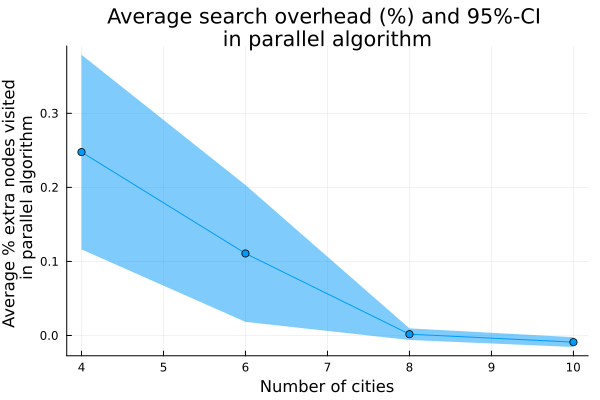

In [16]:
using Distributed
using Plots
using Statistics

# Generate random matrices
function rand_symmetric_distance_table(n)
    threshold = 0.2
    mincost = 3
    maxcost = 10
    infinity = 10000*maxcost
    C = fill(infinity,n,n)
    for j in 1:n
      for i in 1:j
        if rand() > threshold
          C[i,j] = rand(mincost:maxcost)
          C[j,i] = C[i,j]
        end
      end
      C[j,j] = 0
    end
    C,infinity
end

# Sort to get ascending distance weights
function sort_neighbors(C)
    n = size(C,1)
    map(1:n) do i
        Ci = C[i,:]
        cities = sortperm(Ci)
        distances = Ci[cities]
        collect(zip(cities,distances))[2:end]
    end
end

n_cities = [4, 6, 8, 10]
n_rep = 10
city = 1
node_count_serial = zeros(Union{Missing,Int64},length(n_cities), n_rep)
node_count_dist = zeros(Union{Missing,Int64},length(n_cities), n_rep)
for (i, n) in enumerate(n_cities)
    @show n
    for j in 1:n_rep
        # Generate random connections matrix
        C, inf = rand_symmetric_distance_table(n)
        C = sort_neighbors(C)
        # Run serial algorithm
        path, distance, ncount_serial = tsp_serial(C, city)
        # Check if graph is connected 
        if  distance >= inf
            println("The input graph size $n, it $j is not connected")
            node_count_serial[i,j] = missing
            node_count_dist[i,j] = missing
        else
            path, distance, ncount_dist = tsp_dist(C, city)
            node_count_serial[i,j] = ncount_serial
            node_count_dist[i,j] = ncount_dist
        end
    end
end

# Calculate average and confidence interval
search_overhead_perc = (node_count_dist .- node_count_serial)./node_count_serial
avg_search_overhead = [mean(skipmissing(search_overhead_perc[i,:])) for i in axes(search_overhead_perc,1)]
conf_int = [1.96*std(skipmissing(search_overhead_perc[i,:]))/
        sqrt(count(!ismissing,search_overhead_perc[i,:])) 
        for i in axes(search_overhead_perc,1)]

# Plot
plot(n_cities, avg_search_overhead, ribbon=conf_int, markershape=:circle, legend=false)
title!("Average search overhead (%) and 95%-CI \nin parallel algorithm")
ylabel!("Average % extra nodes visited \n in parallel algorithm")
xlabel!("Number of cities")

# License

TODO: replace link to website

This notebook is part of the course [Programming Large Scale Parallel Systems](http://localhost:8000/) at Vrije Universiteit Amsterdam and may be used under a [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/) license.